<a href="https://colab.research.google.com/github/M-MSilva/Analyzing-User-Satisfaction-in-Applications---end_to_end_project/blob/main/jupyterNotebook/Analyzing_User_Satisfaction_in_ApplicationsNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing User Satisfaction in Applications - end_to_end 


A finalidade deste projeto é realizar uma análise de sentimentos, para entender a opinião de usuários em relação aos aplicativos e produtos da google play. Portanto queremos compreender o ponto de vista de usuários a respeito dos aplicativos da google play, para isso examinaremos as críticas e comentários que tais usuários realizaram na plataforma. Além disso, reponderemos as perguntas de negócios:

1. Quais dias que as atualizações foram feitas, que mais influenciaram no número de instalações?
2. Qual exatamente são os aplicativos com mais instalações?
3. Quais categorias, Gêneros e classificações de maturidade dos apps que mais foram instalados ?
4. Quais Categorias, Gêneros, classificações de maturidade que foram mais bem avaliados pelos usuários?
5.  Quais foram exatamente os aplicativo com maiores pontuações?



## 1 - Initial Requirements

Always at the beginning of a project we must import some elementary libraries.



In [ ]:
#Para tratamento de dados
import pandas as pd
import numpy as np

#images
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme()

#para trabalhar dados e organizar pastas
import os
import urllib.request
import zipfile


#para previsão usaremos redes neurais
import tensorflow as tf
from tensorflow  import keras

#para ignorar warnings desnecessários
import warnings
warnings.filterwarnings("ignore")

## 2 - Download Data

Primeiramente definimos o ambiente em que deixaremos nossos dados, cuja pasta será /Sentimental_Analysis/GoogleData/, no passo seguinte coletamos os dados zipados do link abaixo, por fim enviamos os dados para esta pasta, e extraímos todos eles para tornar os conjuntos de dados de csv em dataframe. O link dos original dos dados https://www.kaggle.com/datasets/lava18/google-play-store-apps e licença é https://creativecommons.org/licenses/by/3.0/. Vale notar que alteramos um pouco os dados, como poder ser visto na seção engenharia de dados.

In [ ]:
#pegamos o url do download e selecionamos onde queremos que nossos dados estejam
DOWNLOAD = 'https://github.com/M-MSilva/Analyzing-User-Satisfaction-in-Applications---end_to_end_project/blob/main/DataForGoogleApps/GoogleAppsData.zip?raw=true'
DATA_PATH = os.path.join("Sentimental_Analysis", "GoogleData")
LocalData = "Sentimental_Analysis/GoogleData/GoogleAppsData.zip"
DATA_URL = DOWNLOAD + LocalData

#Extraímos todos os dados zipados e colocamos na pasta /Sentimental_Analysis/GoogleData/
def getting_data_from_google(data_url=DATA_URL, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, "GoogleAppsData.zip")
    urllib.request.urlretrieve(data_url,zip_path)
    archive = zipfile.ZipFile(zip_path, 'r')
    archive.extractall(path=data_path)
    archive.close()

#chamamos a função
getting_data_from_google()

#pegamos os arquivos csv e os transformamos em dataframes
csv_path_googleplaystore = os.path.join(DATA_PATH, "googleplaystore.csv")
csv_path_userApps = os.path.join(DATA_PATH, "googleplaystore_user_reviews.csv")

googleplaystore = pd.read_csv(csv_path_googleplaystore,encoding='utf-8',decimal='.', thousands=',')
googleplaystore_user_reviews = pd.read_csv(csv_path_userApps,encoding='utf-8', thousands=',')

Aqui temos dois conjuntos de dados, provavelmente usaremos googleplaystore mais para obter insights, visualização de dados e responder perguntas de negócios, já o conjunto de dados googleplaystore_user_reviews será empregado no modelo.

## 3 - Initial Data Insights

Como visto acima temos dois conjuntos de dados, portanto em todas as etapas tentaremos extrair informações de ambos conjuntos de dados. Após toda a configuração inicial, estamos prontos para trabalhar e extrair algumas informações preciosas de nossos dados. Primeiro, usamos o método head() no dataframe para entender melhor o conjunto de dados.

In [ ]:
googleplaystore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Cada linha desse dataframe nos dá informações a cerca de um aplicativo, que contém diversos recursos sobre eles.

In [ ]:
googleplaystore_user_reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


Já este dataframe possui 100 avaliações de cada aplicativo, ou seja cada linha é uma avaliação diferente, mas alguns aplicativos podem se repetir, apesar de ter uma avaliação diferente para cada um.

### 3.1 - Glossary of user reviews

Agora vamos entender melhor os dados do arquivo 'googleplaystore_user_reviews', já que possui alguns recursos diferenciados, não farei o mesmo para o outro arquivo, pois aqueles dados são autoexplicativos.

*   App: Nome do Aplicativo;
*   Translated_Review: Revisão do usuário (Pré-processado e traduzido para o inglês);
* Sentiment: Dado que nos diz se o usuário gostou ou não do aplicativo, ou seja sentimento positivo, neutro, ou negativo (categórico);
* Sentiment_Polarity: Similar ao anterior, esse dado nos informa à positividade ou negatividade de uma afirmação, a dirença é que aqui temos valores que vão de [-1,1], logo temos sentimentos positivos e negativos de afirmações na forma de números.
* Sentiment_Subjectivity: Nos diz a intencidade  que um usuário aprecia o aplicativo e expõe (ou declara) o seu ponto de vista sobre ele. O domínio dessa variável varia entre [0,1], 0,0 é muito objetivo e 1,0 é muito subjetivo.



As Frases subjetivas relatam a opinião pessoal, julgamento ou emoções, ao passo que objetivas fazem aluzão a informações factuais. 

### 3.2 - Dataset Summary

After understanding some attributes, we can get a description of the data with the info() method.

In [ ]:
googleplaystore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Notamos que esse conjunto de dados possui 10841 linhas, como também percebemos que alguns dados estão em tipos errados, que é o caso do size e Installs. Podemos verificar também, se existe dados poluídos no outro conjunto de dados:

In [ ]:
googleplaystore_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


Parece que esse último conjunto de dados não precisará de limnpeza inicial, apenas de tratamento posterior.

### 3.3 - Pré Processamento

como nossos dados estão poluídos limparemos elesum pouco usando o .replace() :

In [ ]:
googleplaystore.replace({'Installs':{'\+': '',',':'','Free':''},'Android Ver':{'and up': '','and up': ''},
                         'Price':{'\$': '','$':'','Everyone': np.nan},'Size':{"Varies with device":'',"\+":'',"1,000":'1'},
                         'Android Ver':{"Varies with device":'Varies/device'},'Rating':{19:1.9}},inplace=True,regex=True)
                      



fazemos que o tamanho do aplicativo fique sempre na unidade de medida megabite, e transformamos a coluna Size em numérica.

In [ ]:
def ToMegabyte(data):
    if type(data) == float or type(data) == int:
      return data
    if 'k' in data:
        if len(data) > 1:
          return (float(data.replace('k', ''))*0.001)
    if 'B' in data:
      return float(data.replace('B', '')) * 1e-6
    if 'G' in data:
      return float(data.replace('G', ''))*1000
    if 'M' in data:
      return float(data.replace('M', ''))
    else:
      return data

googleplaystore['Size'] = pd.to_numeric(googleplaystore['Size'].apply(ToMegabyte))

Realizamos um operação semelhente aqui:

In [ ]:
def tomillion(data):
    if type(data) == float or type(data) == int:
      return data
    elif 'M' in data:
        if len(data) > 1:
          return (float(data.replace('M', '')))*1e6
    else:
      return data

googleplaystore['Reviews'] = pd.to_numeric(googleplaystore['Reviews'].apply(tomillion))


E transformamos as strings em datas:

In [ ]:
from datetime import datetime

def to_date(d):
  try:
    return datetime.strptime(d, '%B %d, %Y').strftime('%Y-%m-%d')
  except ValueError:
    return pd.NaT

googleplaystore['Last Updated'] = googleplaystore['Last Updated'].apply(to_date).astype('datetime64[D]')

por fim mudamos o preço e o Installs para serem números e retiramos todos os apps duplicados:

In [ ]:
googleplaystore['Price'] = pd.to_numeric(googleplaystore['Price'])
googleplaystore['Installs'] = pd.to_numeric(googleplaystore['Installs'])
googleplaystore.shape

(10841, 13)

In [ ]:
googleplaystore.drop_duplicates(subset='App', inplace=True, ignore_index=True)
googleplaystore.shape

(9660, 13)

Também possuímos apps repetidos no outro conjunto de dados, entretanto, como lá temos críticas diferentes em referência a um mesmo app, logo devemos manter o dataset assim.

### 3.4 - Understanding the data

#### 3.4.1 - Dados Numéricos

Agora que sabemos quais são nossos atributos numéricos podemos plotá-los na forma de um histograma. Vamos plotar várias informações do aplicativo no eixo x pela densidade de frequência no eixo y usando o dataframe googleplaystore.

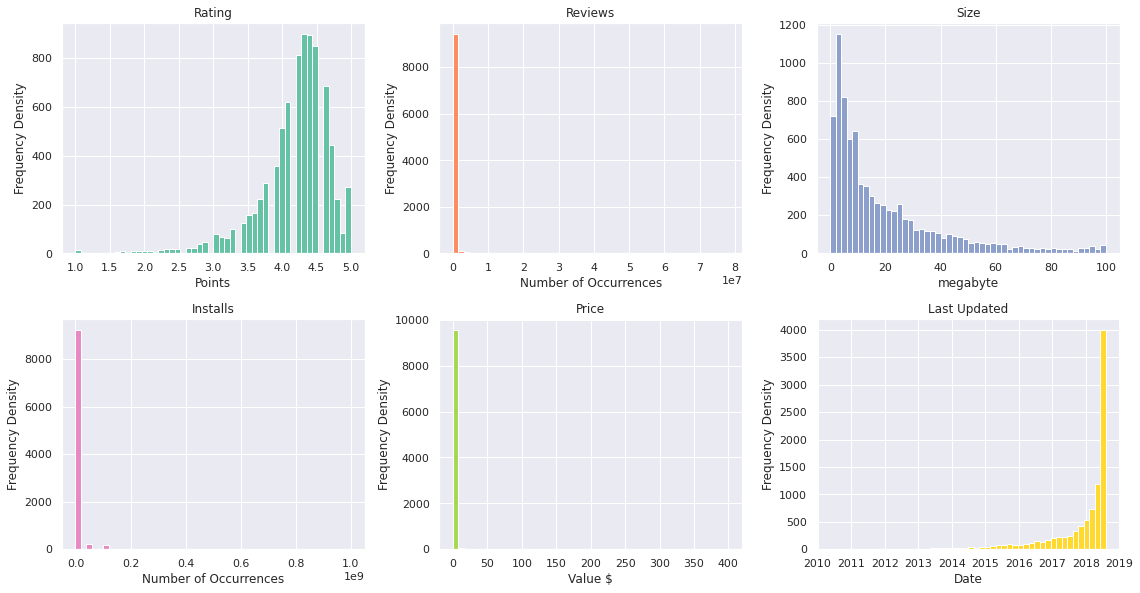

In [ ]:
cmap = mpl.cm.Set2

gAppCopy = googleplaystore.copy()
gReviewCopy = googleplaystore_user_reviews.copy()

fig=plt.figure(figsize=(16,12))

#list with the x label
measurement = ['Points','Number of Occurrences',
               'megabyte','Number of Occurrences','Value $','Date']

gOne_num = list(googleplaystore.select_dtypes(include=[np.number]))
gOne_num.append("Last Updated")

#loop that plots all the charts we want, using the hist() method
for i, x, in zip(enumerate(gOne_num),measurement):
  ax=fig.add_subplot(3,3,i[0]+1)
  gAppCopy[i[1]].hist(bins=50,ax=ax,color=cmap(i[0]))
  ax.set_xlabel(x)
  ax.set_ylabel('Frequency Density')
  ax.set_title(i[1])
fig.tight_layout()
plt.show()

Vale notar que alguns dados possuem valores altos de mais e baixos de mais, como a maior concentradção de dados geralmente é em valores menores, parece que só temos poucos dados menores, mas temos valores altos também.

In [ ]:
print("max price: %s $, and the max Reviews: %s reviews" % (max(gAppCopy['Price']), max(gAppCopy['Reviews'])))

max price: 400.0 $, and the max Reviews: 78158306.0 reviews


Ademais, no gráfico acima precebemos que a maioria do rating está em 4.5 pontos, e a maioria dos aplicativos da google play são gratúitos, outor interessante no nosso conjunto de dados parece ser o tamanho do aplicativo, que é bem mais distribuído do que os outros dados, além de nos mostrar que a maioria dos aplicativos parece possuir 2 mb. Por fim vemos que os aplicativos foram mais atualizados em 2019 do que nos outros anos.

Fazemos o mesmo com o dataframe User Review:

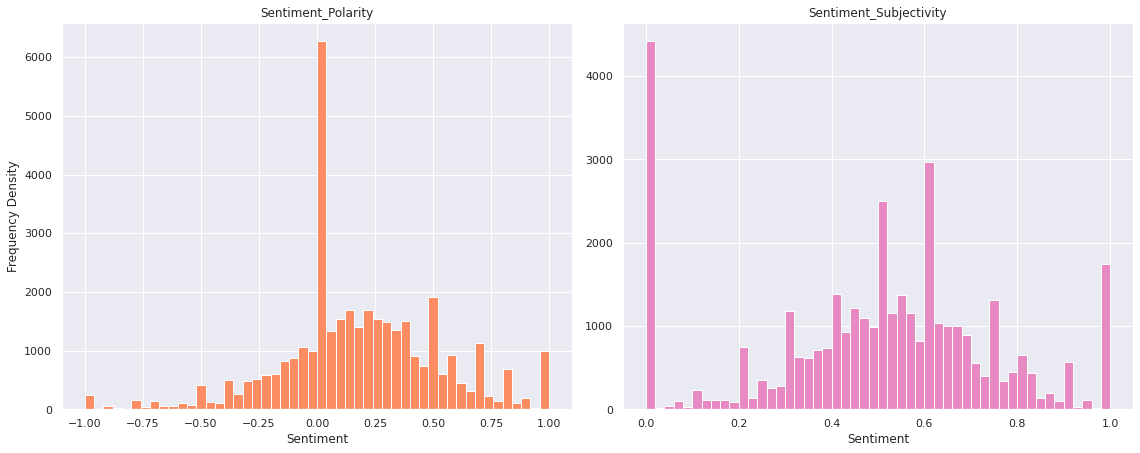

In [ ]:
cmap = mpl.cm.Set2

fig=plt.figure(figsize=(16,12))

#plotamos o Sentiment Polarity
ax=fig.add_subplot(2,2,1)
gReviewCopy['Sentiment_Polarity'].hist(bins=50,ax=ax,color=cmap(1))
ax.set_ylabel('Frequency Density')
ax.set_title('Sentiment_Polarity')
ax.set_xlabel('Sentiment')
fig.tight_layout()


#plotamos o Sentiment Subjectivity
ax=fig.add_subplot(2,2,2)
gReviewCopy['Sentiment_Subjectivity'].hist(bins=50,ax=ax,color=cmap(3))
ax.set_xlabel('Sentiment')
ax.set_title('Sentiment_Subjectivity')
fig.tight_layout()

plt.show()

E notamos que a maioria das afirmações são neutras, já a na variável Sentiment Subjectivity percebemos quea maioria das frases relatadas são objetivas.

To understand the data in an easier way, we will use the describe() method:

In [ ]:
gAppCopy.describe()

,Rating,Reviews,Size,Installs,Price
count,8197.000000,9.660000e+03,8433.000000,9.659000e+03,9659.000000
mean,4.172966,2.168807e+05,20.392989,7.777507e+06,1.099299
std,0.537179,1.831444e+06,21.827270,5.375828e+07,16.852152
min,1.000000,0.000000e+00,0.008500,0.000000e+00,0.000000
25%,4.000000,2.500000e+01,4.600000,1.000000e+03,0.000000
50%,4.300000,9.670000e+02,12.000000,1.000000e+05,0.000000
75%,4.500000,2.942025e+04,28.000000,1.000000e+06,0.000000
max,5.000000,7.815831e+07,100.000000,1.000000e+09,400.000000


Captamos o baixo desvio padrão do Rating indicando a maior proximidade dos dados em relação a média, Reviews e Installs  possuem um alto desvio padrão apontanto a maior dispersão de dados em relação a média, além de outras informações auto-explicativas.

In [ ]:
gReviewCopy.describe()

,Sentiment_Polarity,Sentiment_Subjectivity
count,37432.000000,37432.000000
mean,0.182146,0.492704
std,0.351301,0.259949
min,-1.000000,0.000000
25%,0.000000,0.357143
50%,0.150000,0.514286
75%,0.400000,0.650000
max,1.000000,1.000000


Aqui verificamos o baixo desvio padrão em ambas os recursos, como também uma média muito baixa já que o domínio de Sentiment_Polarity, Sentiment_Subjectivity são pequenos.

#### 3.4.2 - Dados Categóricos

Tinhamos obtido mais informações a respeito de nossos dados numericos, agora é hora de entender os dados categoricos, como alguns dados categóricos são imensos, logo devemos plotar apenas os mais fáceis de serem visualizados no conjunto de dados googleplaystore, e para isso usamos o método .value_counts().

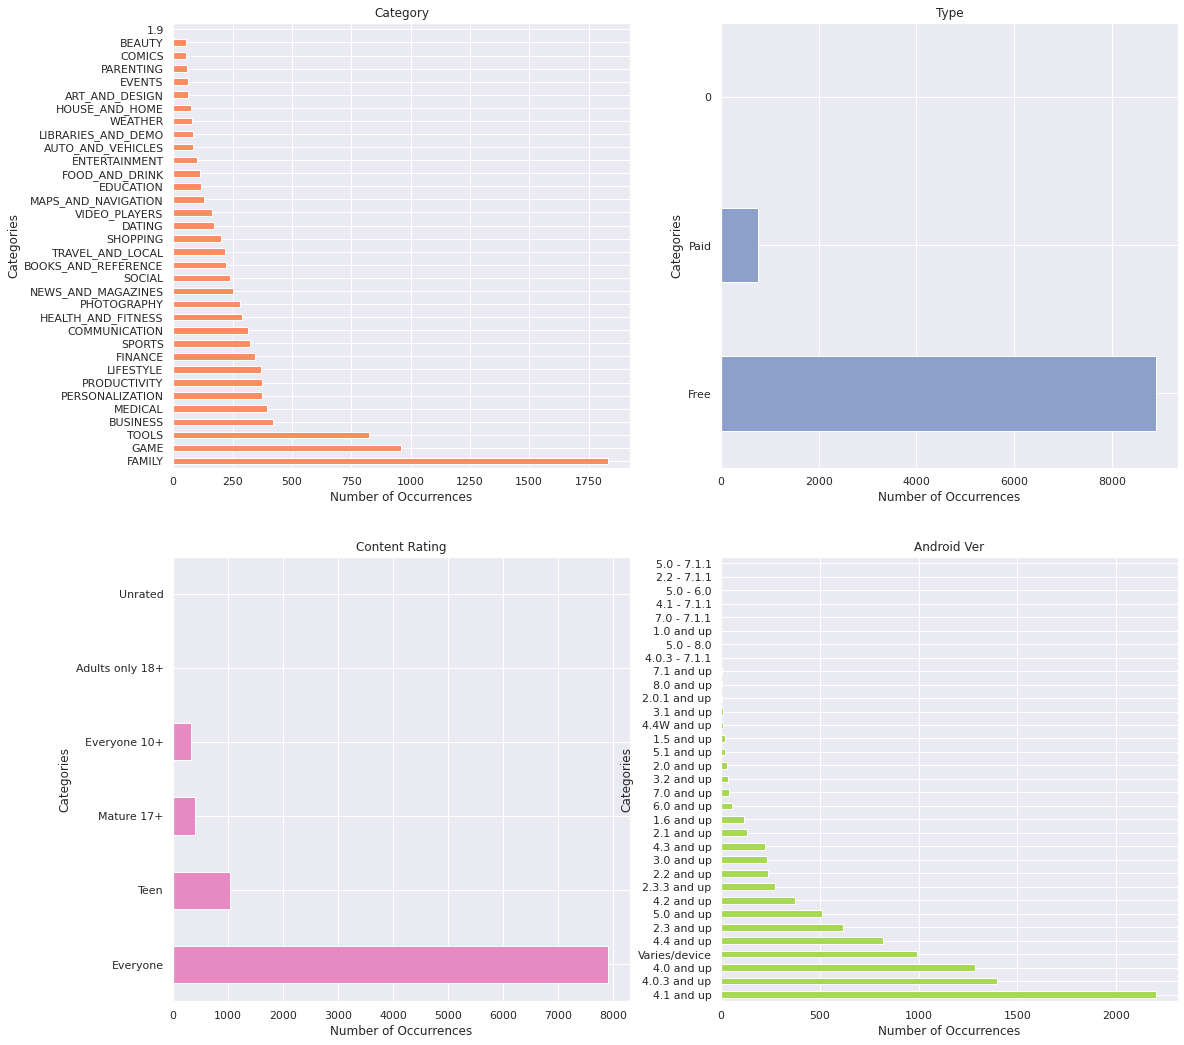

In [ ]:
gpObject = ['Category','Type','Content Rating','Android Ver']

fig=plt.figure(figsize=(18,18))

#loop that plots all the data we want using the value_counts() method
for i, col in enumerate(gpObject):
  ax=fig.add_subplot(2,2,i+1)
  plt.xlabel('Number of Occurrences')
  plt.ylabel('Categories')
  valuec = gAppCopy[col].value_counts().plot(kind='barh',title=col,color=cmap(i + 1),grid=True,ax=ax)
plt.show()

Observamos que as maiores ocorrencias para a categoria, tipo, content rating e android version são respectivamente ~ ( 1750 para family,8000 para free,8000 para everyone, 2300 para 4.1). Além disso alguns dados não foram plotados aqui, pois possuem muitas categorias como é o caso do gênere, mas podemos plotar ta informação, selecionando apenas as 10 maiores ocorrencias da categoria

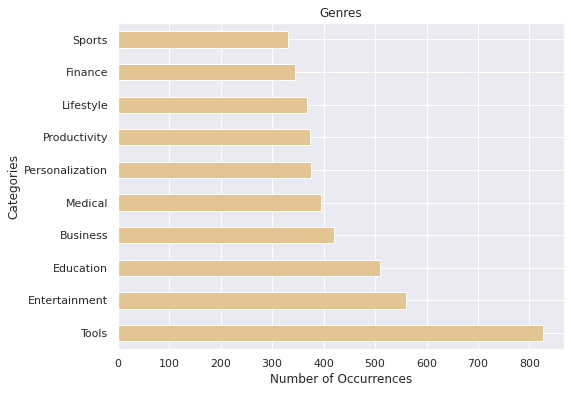

In [ ]:
n = 10
plt.xlabel('Number of Occurrences')
plt.ylabel('Categories')
gAppCopy['Genres'].value_counts()[:n].plot(kind='barh',title=col,color=cmap(6),grid=True,figsize=(8,6))
plt.title('Genres')
plt.show()

Fica evidente pelo gráfico acima, que tools e entretainment são os gêneros com mias ocorrecias no conjunto de dados. No outro conjunto de dados, apenas pela variável sentment conseguimos vizualizar algo:

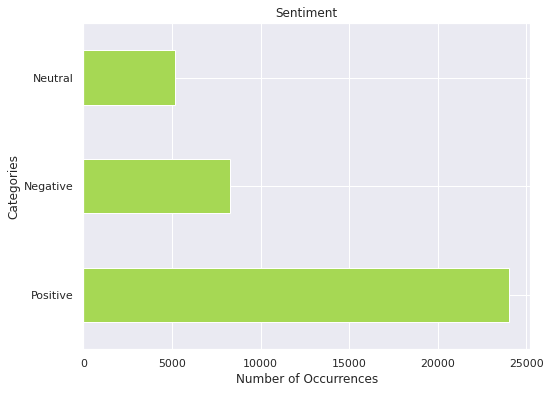

In [ ]:
plt.xlabel('Number of Occurrences')
plt.ylabel('Categories')
gReviewCopy['Sentiment'].value_counts().plot(kind='barh',title=col,color=cmap(4),grid=True,figsize=(8,6))
plt.title('Sentiment')
plt.show()

A classe positiva é que possui mais ocorrências, como também concorda com os dados de rating do dataset googleplaystore, já que pela seção 3.2 econtramos a média e a mediana do raintg de ~ 4.2

## 5 - Visualizing data and Answering Some Business Questions

Chegou a hora de uma das partes mais legais de projeto, já que depois de obter insights de nossos dados devemos responder às perguntas de negócios, antes de passar para o modelo de aprendizado de máquina.

#### 5.1 -  Melhor dia Para realizar uma atualização on aplicativo

A primeira pergunta que vamos responder é: quais dias que as atualizações foram feitas, que mais influenciaram no número de instalações? Para responder esssa pergunta agruparemos os dados em dias do mês e somaremos os dados que acontecem no mesmo dia, ou seja agregaremos valores para cada coluna no dataset por dia, assim como pode ser visto no resultado abaixo.

In [ ]:
fordate = googleplaystore.copy()

fordate.replace([np.inf, -np.inf], np.nan, inplace=True)

fordate.dropna(subset=["Last Updated"], how="all", inplace=True)

fordate['Day'] = fordate['Last Updated'].dt.day.astype(int)

results = fordate.groupby('Day').sum()

results.head()

,Rating,Reviews,Size,Installs,Price
Day,,,,,
1,1576.8,173630102.0,8580.874,6.870185e+09,1313.00
2,1628.8,166003367.0,9200.522,6.071260e+09,122.64
3,2016.7,371269755.0,9579.229,1.061718e+10,546.43
4,1108.9,91929649.0,5307.997,2.295793e+09,126.26
5,1255.3,68946815.0,5432.574,2.260111e+09,193.42


Plotamos o resultado:

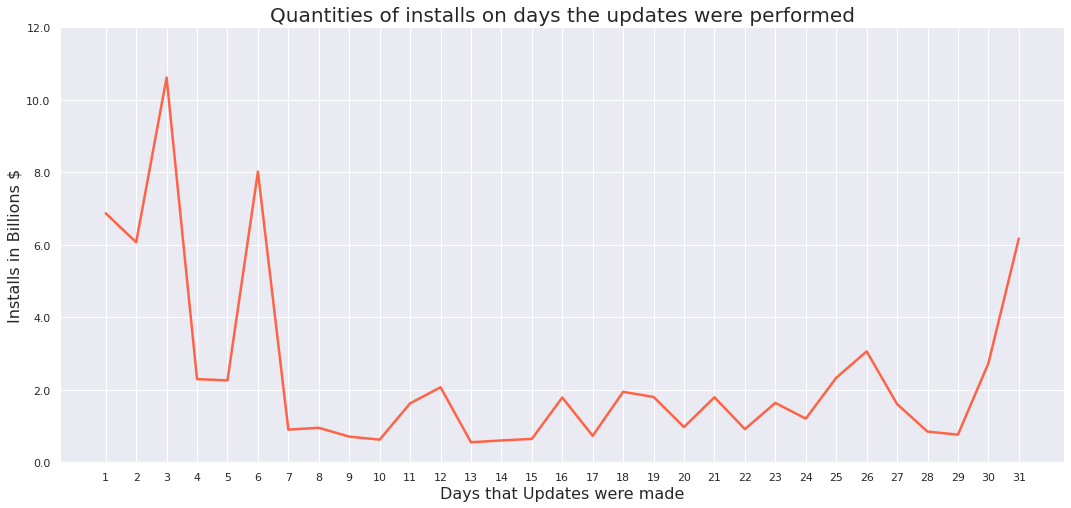

In [ ]:
day = range(1,32)

#plotamos
fig=plt.figure(figsize=(18,8))
plt.plot(day,results['Installs'],lw=2.5,color='tomato')
labels,location = plt.yticks()
plt.yticks(labels,(labels/1e9))
plt.xticks(day)
plt.ylabel('Installs in Billions $',fontsize=16)
plt.xlabel('Days that Updates were made',fontsize=16)
plt.title('Quantities of installs on days the updates were performed',fontsize=20)
plt.show()

Aqui notamos que o dia que houve mais instações foi no dia 3, isso significa que o melhor dia para realizar uma atualização é no dia 3, visto que haverá mais baixamentos.

#### 5.2 - Most installed apps on Devices

E se quisermos saber qual exatamente são os aplicativos com mais instalações? Com esta finalidade pegaremos os 9 aplicativos com mais instações usando o método .nlargest()

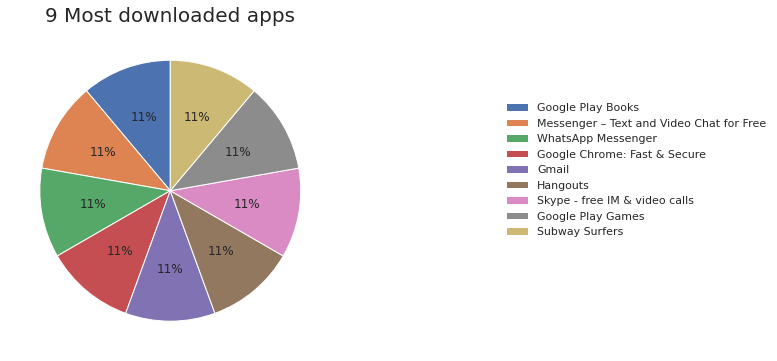

In [ ]:
anotherCopy = googleplaystore.copy()

anotherCopy = anotherCopy[anotherCopy['Installs'].notna()]

anotherCopy = anotherCopy.nlargest(9, columns=['Installs'])

#plotamos
fig = plt.figure(figsize =(10, 6))
plt.pie(anotherCopy['Installs'],
        shadow=False, startangle=90,autopct='%1.0f%%')
plt.title('9 Most downloaded apps',fontsize = 20)
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8),labels=anotherCopy['App'])
plt.show()


Ou nosso conjunto de dados é ruim e não possui informações significantes sobre os apps, ou todos esses dados possuem os mesmos números de downloads. Já que não encontramos boas informações dos apps individuas, vamos agrupar alguns dos apps em classes.

#### 5.3 - Most installed App Classes 

Queremos saber agora quais categorias, Gêneros e classificações de maturidade dos apps que mais foram instaldos. Para responder a essa pergunta vamos usar o método groupby('variable').sum() para agrupar dados da mesma classe e somar esses dados.

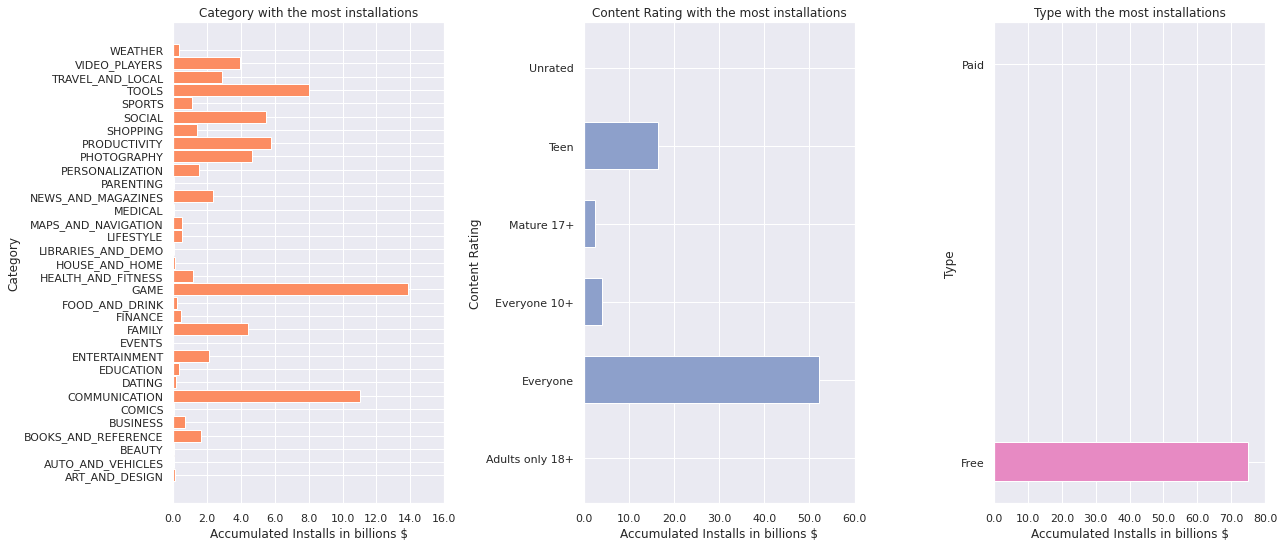

In [ ]:
#color map we use 
cmap3 = mpl.cm.Set2

#PEGAMOS APENAS OS DADOS ACIMA DA MÉDIA
justForvisu = gAppCopy[gAppCopy['Installs']>10000].copy()

labels1 = [cat for cat, justForvisu in justForvisu.groupby('Category')] 
labels3 = [typee for typee, justForvisu in justForvisu.groupby('Type')]
labels2= [cr for cr, justForvisu in justForvisu.groupby('Content Rating')]

#dictionary containing the labels to plot
apps_dict = {'l1':labels1,'l2':labels2,'l3':labels3}

#the list that we are going to go through to find the best ponctuate for each category
resultsList = ['Category','Content Rating','Type']

fig=plt.figure(figsize=(18,22))

height=[0.9,0.6,0.1]

for val,i,j in zip(enumerate(apps_dict.values()),resultsList,height):
  #use the groupby('Category').sum() methods to group the tracks for example and sum the data of their group
  results = justForvisu.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)
  #we plot the vertical bar
  ax.barh(val[1],results['Installs'],color=cmap3(val[0] + 1),height=j)
  labels,location = plt.xticks()
  plt.xticks(labels,(labels/1e9))
  ax.set_ylabel(i)
  ax.set_xlabel('Accumulated Installs in billions $')
  ax.set_title(i + ' with the most installations')
fig.tight_layout()
plt.show()

Aqui vemos que a categoria dos aplicativos que mais instalados foram os games e os apps de comunicação, como também os aplicativos mais instalados foram aqueles livres para qualquer públoco e de graça.

#### 5.4 - Top rated app classes

A próxima pergunta que responderemos é: quais Categorias, Gêneros, classificações de maturidade que foram mais bem avaliados pelos usuários? Para responder a essa pergunta vamos usar o método groupby('variable').sum() para agrupar dados da mesma classe e somar esses dados.




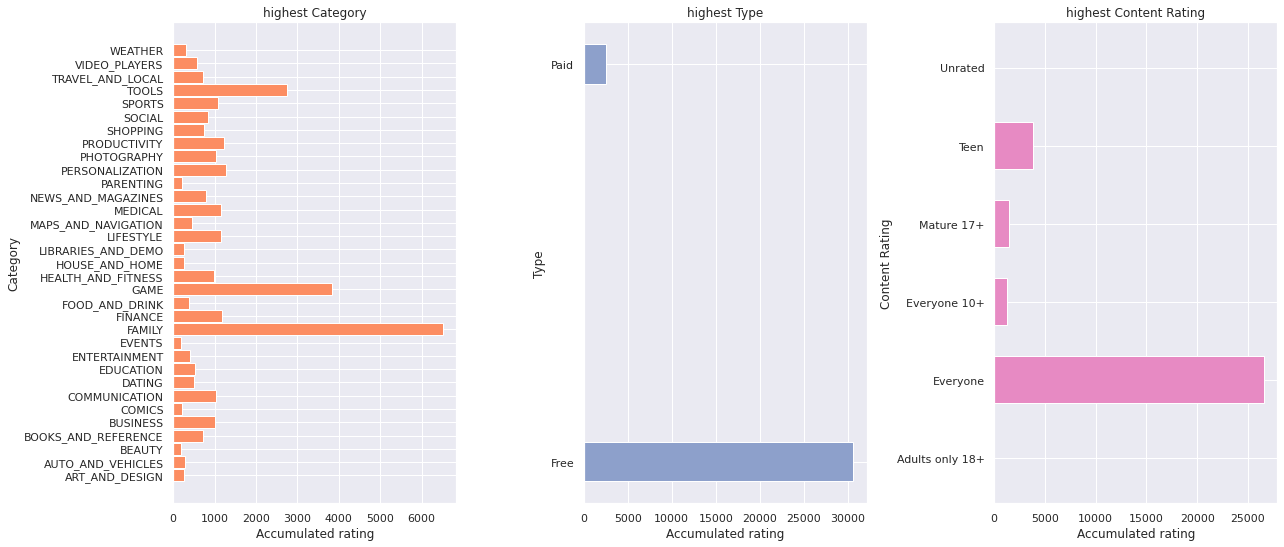

In [ ]:
#color map we use 
cmap3 = mpl.cm.Set2

#PEGAMOS APENAS OS DADOS ACIMA DA MÉDIA
justForvisuTwo = gAppCopy[gAppCopy['Rating']>3.1].copy()

labels1 = [cat for cat, justForvisuTwo in justForvisuTwo.groupby('Category')] 
labels2 = [typee for typee, justForvisuTwo in justForvisuTwo.groupby('Type')]
labels3= [cr for cr, justForvisuTwo in justForvisuTwo.groupby('Content Rating')]

#dictionary containing the labels to plot
apps_dict = {'l1':labels1,'l2':labels2,'l3':labels3}

#the list that we are going to go through to find the best ponctuate for each category
resultsList = ['Category','Type','Content Rating']

fig=plt.figure(figsize=(18,22))

height=[0.9,0.1,0.6]

for val,i,j in zip(enumerate(apps_dict.values()),resultsList,height):
  #use the groupby('Category').sum() methods to group the tracks for example and sum the data of their group
  results = justForvisuTwo.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)
  #we plot the vertical bar
  ax.barh(val[1],results['Rating'],color=cmap3(val[0] + 1),height=j)
  ax.set_ylabel(i)
  ax.set_xlabel('Accumulated rating')
  ax.set_title('highest ' + i)
fig.tight_layout()
plt.show()

Notamos nesses gráficos que os aplicativos com maiores ratings são os familiares, gratuitos e que uma pessoa de qualquer idade pode jogar.

#### 5.5 - Apps com Maior avaliação



Para responder a pergunta 'Quais foram exatamente os aplicativo com maiores pontuações?' devemos primeiro pegar além dos melhores ratings, os maiores números de reviwes, pois não adianta ter um alto rating se apenas uma pessoa avaliou como por exemplo.



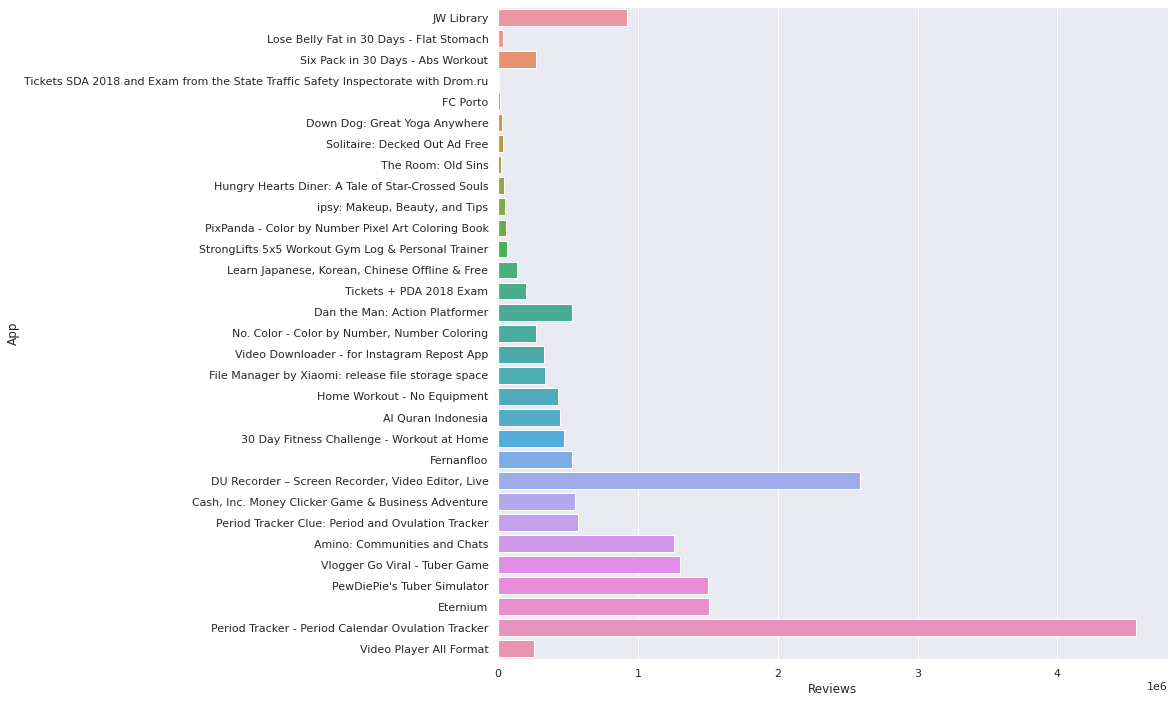

In [ ]:
#we plot

#pegamos os maiores Ratings e Reviews.
aux = gAppCopy[(gAppCopy['Rating']>4.3) & (gAppCopy['Reviews']>10000)]


#selecionamos apenas os maiores Reviews, Rating, Installs
justForvisu = aux.nlargest(31, columns=['Rating','Reviews','Installs'],keep='all').copy().sort_values('Rating',ascending=False)


plt.figure(figsize = (12,12))

#já que todos esses apps tem altos rankings a maneira de compará-los é pelo número de Reviews
sns.barplot(x = justForvisu['Reviews'], y =justForvisu['App'])
plt.show()

Os ratings estão em ordem decrescente, portanto jm library é o app com maior rating.

## 6 -  Análise exploratória de dados e Feature engenering

Nessa parte do código faremos muita coisa para extrair informação dos nossos dados, mas primeiramente pegaremos uma cópia do dataset googleplaystore_user_reviews e veremos o que tem dentro dele:

In [ ]:
user_reviews_copy = googleplaystore_user_reviews.copy()

user_reviews_copy['Translated_Review'].unique()

array(['I like eat delicious food. That\'s I\'m cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"',
       'This help eating healthy exercise regular basis', nan, ...,
       'Dumb app, I wanted post property rent give option. Website work. Waste time space phone.',
       'I property business got link SMS happy performance still guys need raise bar guys Cheers',
       'Useless app, I searched flats kondapur, Hyderabad . None number reachable I know flats unavailable would keep posts active'],
      dtype=object)

### 6.1 - Mais um pouco de pré-processamento

Nos dados de texto dispomos de dados NaN, por isso excluiremos esses dados usando .notna()

In [ ]:
user_reviews_copy = user_reviews_copy[user_reviews_copy['Translated_Review'].notna()]

Notamos também que possuímos alguns caracters que podem prejudicar tanto a nossa análise quanto o nosso modelo, portanto aplicaremos muito tratamento em nossos dados.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import re
import sys

#criamos ums função para retirar tags e tudo o que não for texto,
def preprocess(data):
    data = re.sub(r"<(?!br).*?>", " ",data)
    data = re.sub(r"[^a-zA-Z]", " ",data)
    return data

#aplicamos a função acima nas críticas,
user_reviews_copy['Translated_Review'] = user_reviews_copy['Translated_Review'].apply(preprocess)


#retiramos de nossos dados as  palavras irrelevantes que são comuns no inglês como  'I', 'this', 'is', 'in'.
stopwords = STOPWORDS
stopwords.update(['game','it','app','t','s','m'])

#Tornamos o texto maiúsculo para minúsculo,
user_reviews_copy['Translated_Review']= user_reviews_copy['Translated_Review'].\
                                        apply(lambda x: x.lower())

#realizamos de fato a retirada de palavras irrelevantes,
user_reviews_copy['Review_without_stopwords'] = user_reviews_copy['Translated_Review'].\
                                                apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

#pegamos todas a crítica no dataset e juntamos tudo isso em uma única string.
text = ' '.join(t for t in user_reviews_copy['Review_without_stopwords'])

### 6.2 - WordCloud e as palavras mais frequentes nas críticas

Agora que limpamos nossos dados vamos visualizar as palavras mais frequentes usando uma nuvem de palavras, neste gráfico o tamanho da palavra representa sua importância ou frequência.

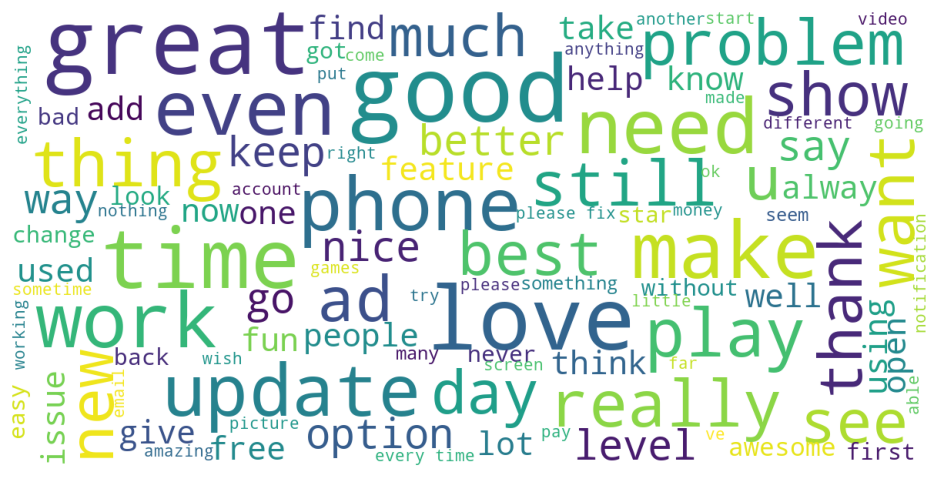

In [ ]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib

#Retiramos o fundo do seaborn,
matplotlib.rc_file_defaults()

#escolhemos o tamanho da imagem, como também retiramos o eixo do plot
plt.figure(figsize=(12,6))
plt.axis("off")

# e usamos imshow para ilustra os dados como uma imagem
plt.imshow(
    WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=6).generate(text)
)
plt.show()

Apesar do gráfico acima ser bonito ele é dificil de entender, visto que as palavras estão bagunçadas, portanto vamos plotar as palavras mais frequentes em cada tipo de sentimento 0 negativo, 1 neutro, 2 positivo. Mas a operação não é tão simples assim, já que além de agruparmos as críticas para cada sentimento, também devemos pegar cada palavra mais comum nas críticas, para terem a sua respectiva classe. No fim plotamos gráficos representando esta operação.

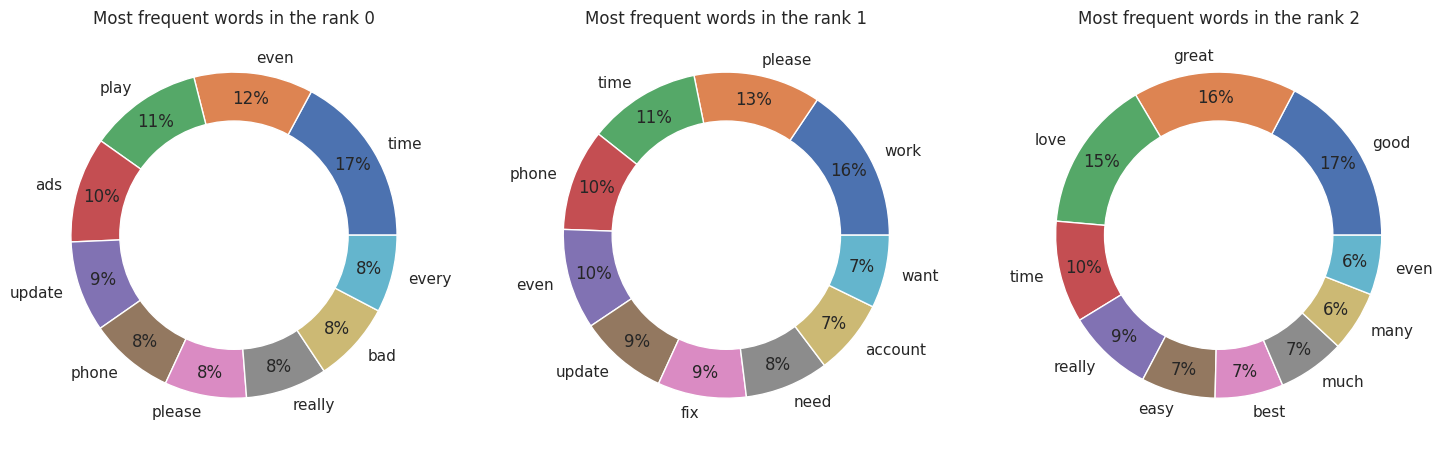

In [ ]:
from collections import Counter

#Agrupamos as palvras nas classes,
group_by = user_reviews_copy.groupby('Sentiment')['Review_without_stopwords'].apply(lambda x: Counter(' '.join(x).split()).most_common(10))

#retornamos  com o tema do seaborn,
sns.set_theme()

#e selecionamos o tamanho da imagem.
fig=plt.figure(figsize=(18,18))

#Plotamos os três gráficos extraindo group_by a frequência e as palavras do group by de cada classe:
for i in range(0,3):
  group_bycl = group_by.iloc[i]
  ax=fig.add_subplot(3,3,i+1)
  words,freq = map(list,zip(*group_bycl))

  ax.pie(x=freq,labels=words,autopct='%1.0f%%',pctdistance=0.85)
  ax.set_title('Most frequent words in the rank ' + str(i))

  my_circle=plt.Circle( (0,0), 0.7, color='white')
  p=plt.gcf()
  p.gca().add_artist(my_circle)
plt.show()


Neste gráfico observamos nas críticas negativas que temos 'ads' como sendo uma palavra frequente, isso significa que os piores aplicativos são aqueles com muitas propagandas, já nas críticas neutras notamos a prevalência de fix, que aponta algum problema ou bug no jogo. Ademais nessa mesma classe temos a predominância da palavra acoount, que indica aplicativos que provavelmente forçam criar conta para uso. Já na última classe, a positiva só tem coisa boa.

### 6.3 - Entendendo o Ngram nos dados

Por conseguinte, para compreender melhor as críticas dos usuários vamos contemplar o que chamamos de ngram, cujos significados são sequências de palavras encontradas no texto, exemplo um 2-grama = bigrama pode ter as palavras 'wasted time' indicando uma experiência ruim de um usuário  nos aplicativos.


In [ ]:
# Inicialmente criamos três listas com as críticas posivas, negativas e neutras,
positive = user_reviews_copy[user_reviews_copy['Sentiment']=='Positive']['Review_without_stopwords'].values.tolist()
neutral = user_reviews_copy[user_reviews_copy['Sentiment']=='Neutral']['Review_without_stopwords'].values.tolist()
negative = user_reviews_copy[user_reviews_copy['Sentiment']=='Negative']['Review_without_stopwords'].values.tolist()

em seguida usamos em conjunto a biblioteca nlkt para produzir nossa sequência de ngrams, e a CountVectorizer do sklearn para tokenizar (codificar os caracteres em inteiros) nossos dados. Posteriormente criamos uma matriz (bag_of_words), onde  cada coluna caracteriza uma palavra no vocabulário, e as linhas são um texto individual no corpus, dessa matriz somamos as ocorrencias das paralvas no texto com .sum(axis= 0 ). Finalmente pareamos as palavras e a sua ocorrencia em uma tupla e também ordenamos tais palavras de acordo com a maior frequência.


In [ ]:
from nltk.util import ngrams 
from sklearn.feature_extraction.text import CountVectorizer

#criamos a função explicada acima,
def  topNgram(corpus, n=None) : 
    cVec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_words = cVec.transform(corpus)
    sum_words = bag_words.sum(axis= 0 )
    
    freq_of_words  = []
    for word, idx in cVec.vocabulary_.items():
      freq_of_words.append((word , sum_words[ 0 , idx]))
                   
    freq_of_words.sort(key=lambda tup: tup[1], reverse=True)
    return freq_of_words[:10]

#chamamos a função acima e levamos os top 10 bigramas positivos nas listas xp,yp,
xp,yp=map(list,zip(*topNgram(positive,2)[:10]))

#repetimos a operação acima para os top 10 bigramas neutros.
xN,yN=map(list,zip(*topNgram(neutral,2)[:10]))

#Fazemos o mesmo para os negativos.
xM,yM=map(list,zip(*topNgram(negative,2)[:10]))

#Criamos dataframes com os resultados acima de ngram,frequency, 
#não colocamos em um único dataframe, pois queremos plotar informações de cada classe,
#já que usar um único dataframe seria possível apenas plotar uma dispersão com péssima visualização.
dfpositive = pd.DataFrame(list(zip(xp,yp)), columns = ['ngram','frequency'])
dfNeutr = pd.DataFrame(list(zip(xN,yN)), columns = ['ngram','frequency'])
Negative = pd.DataFrame(list(zip(xM,yM)), columns = ['ngram','frequency'])

Plot das informações geradas acima:

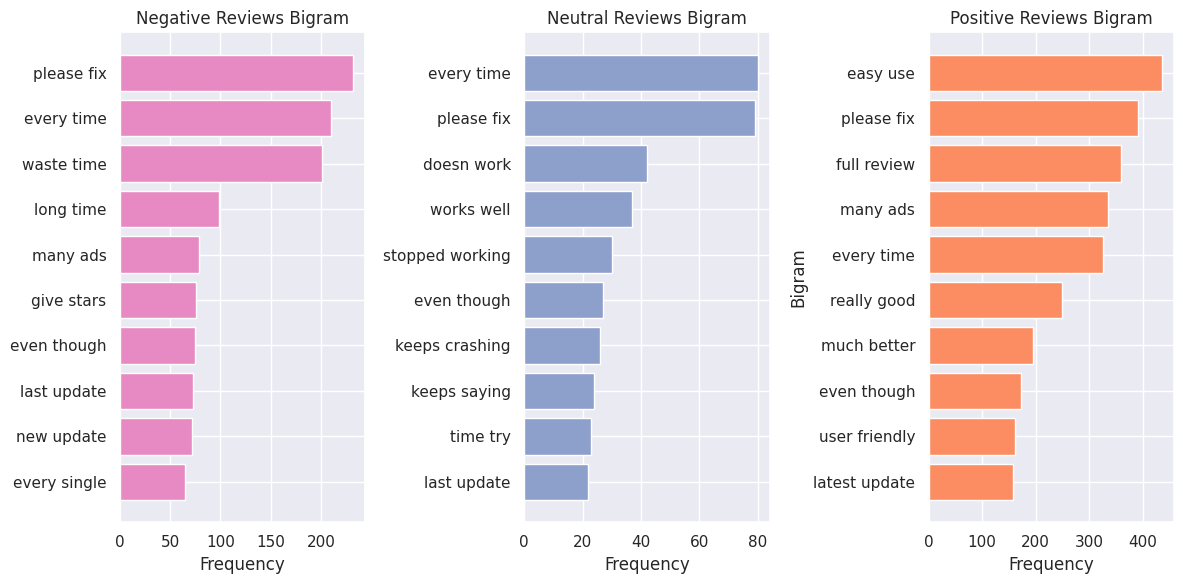

In [ ]:
#Criamos uma figura com três subplots,
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)


#ordenamos o dataframe negativo pela frequencia,
Negative.sort_values(by=['frequency'],inplace=True)

#plotamos do dataframe negativo na forma de barra horizontal.
ax1.barh(Negative['ngram'].values,Negative['frequency'].values,color=cmap3(3))
ax1.set_xlabel('Frequency')
ax1.set_title('Negative Reviews Bigram')



#Fazemos análogo para o dataframe neutro,
dfNeutr.sort_values(by=['frequency'],inplace=True)

ax2.barh(dfNeutr['ngram'].values,dfNeutr['frequency'].values,color=cmap3(2))
ax2.set_xlabel('Frequency')
ax2.set_title('Neutral Reviews Bigram')



#o análogo para o dataframe neutro,
dfpositive.sort_values(by=['frequency'],inplace=True)

ax3.barh(dfpositive['ngram'].values,dfpositive['frequency'].values,color=cmap3(1))
ax3.set_ylabel('Bigram')
ax3.set_xlabel('Frequency')
ax3.set_title('Positive Reviews Bigram')

#selecionamos o tamanho e Ajustamos o preenchimento entre e ao redor dos subplots.
fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()


Nesses Bigramas parace haver concordancia com o gráfico anterior, entrentato, percebemos que tanto nos bigramas positivos, negativos e neutros temos a sequência please fix, isso poderia refutar que as críticas positivas não são positivas, ou que o usuário gostou do app e deu uma classificação boa, apesar de ter encontrada alguns problemas no app. Por isso motraremos uma dessas crítias pósitivas:

In [ ]:
# creating and passing series to new column,
findtext = user_reviews_copy[user_reviews_copy['Sentiment']=='Positive'].copy()

substring = 'please fix'

#encontramos as colunas com a palavra 'please fix'
findtext['found_text'] = findtext['Translated_Review'].str.contains(substring, case=True, flags=0, na=None, regex=True)

#e selecionamos todas as colunas que contém  a sequência 'please fix'.
aux = findtext[findtext['found_text']==True]

Após termos selecionado essas colunas pegamos um exemplo que possui a sequência 'please fix'.

In [ ]:
aux['Translated_Review'][1098]

'so far i like it  the options talk  get help connect great  however qite bugs glitches  i m sure upgrade would offer wouldnt consider bugs worked out  this great idea could help many people  please fix bugs '

Parece que é isso memso, o usuário gostou do app, apesar de bugs.

### 6.4 - Reconhecimento de entidade nomeada

Agora queremos classificar nosso texto em algumas entidades, como países edifícios, datas, instituições, etc, isso ficará mais claro com o exemplo, além disso para realizar a operação usaremos novamente o spacy. Antes de qualquer coisa vislumbraremos todas as entidades que o modelo consegue classificar e sua descrição.

In [ ]:
import spacy

#inicializamos o modelo usando o inglês
nlp = spacy.load( "en_core_web_sm" )

#pegamos os rótulos
labels = nlp.get_pipe("ner").labels

#coletamos a descrição de cada entidade
desc=[spacy.explain(i) for i in labels]

#criamos um dataframe com a entidade e a descrição da entidade para entender melhor
mydf = pd.DataFrame({'Entity': labels,
     'Description': desc
    })

mostramos todas as entidades a seguir:

In [ ]:
mydf

,Entity,Description
0,CARDINAL,Numerals that do not fall under another type
1,DATE,Absolute or relative dates or periods
2,EVENT,"Named hurricanes, battles, wars, sports events..."
3,FAC,"Buildings, airports, highways, bridges, etc."
4,GPE,"Countries, cities, states"
5,LANGUAGE,Any named language
6,LAW,Named documents made into laws.
7,LOC,"Non-GPE locations, mountain ranges, bodies of ..."
8,MONEY,"Monetary values, including unit"
9,NORP,Nationalities or religious or political groups


com o terreno pronto vamos extrair as entidades dos nossos dados para cada classe de sentimento.

In [ ]:
#criamos um dataframe para cada sentimento
positivedf = user_reviews_copy[user_reviews_copy['Sentiment']=='Positive']
neutraldf = user_reviews_copy[user_reviews_copy['Sentiment']=='Neutral']
negativedf = user_reviews_copy[user_reviews_copy['Sentiment']=='Negative']


#criamos uma função que gera uma varivel doc, que contém uma instância com as entidades e partir dela extraímos as entidades
def ner(text):
    doc=nlp(text, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
    return [u.label_ for u in doc.ents]


#aplicamos em uma fração dos nossos dados tratados a função acima,  por fim 
#como nem toda palavra tem entidade, logo excluímos todas as entidades nulas e coletamos as que queremos
entp=positivedf['Review_without_stopwords'][:900].\
    apply(lambda u : ner(u))
entp=[u for sub in entp for u in sub]

#contamos as palavras, depois pegasmos as mais comuns e finalmente levamos  as palavras e as frequancias das palavasr em duas tupplas  
countp=Counter(entp).most_common(7)
px, py = list(zip(*countp))[0], list(zip(*countp))[1]



#fazemos a mesma operação anterior mas com o sentimento neutro
entn=neutraldf['Review_without_stopwords'][:900].\
    apply(lambda u : ner(u))
entn=[u for sub in entn for u in sub]

countern=Counter(entn).most_common(7)
nx, ny = list(zip(*countern))[0], list(zip(*countern))[1]



#fazemos a mesma operação anterior mas com o sentimento negativo
entM=negativedf['Review_without_stopwords'][:900].\
    apply(lambda u : ner(u))
entM=[u for sub in entM for u in sub]

counterM=Counter(entM).most_common(7)
Mx, My = list(zip(*counterM))[0], list(zip(*counterM))[1]


Plotamos a fração das entidades em cada sentimento, pois a operação NER leva muito tempo em dados grandes:

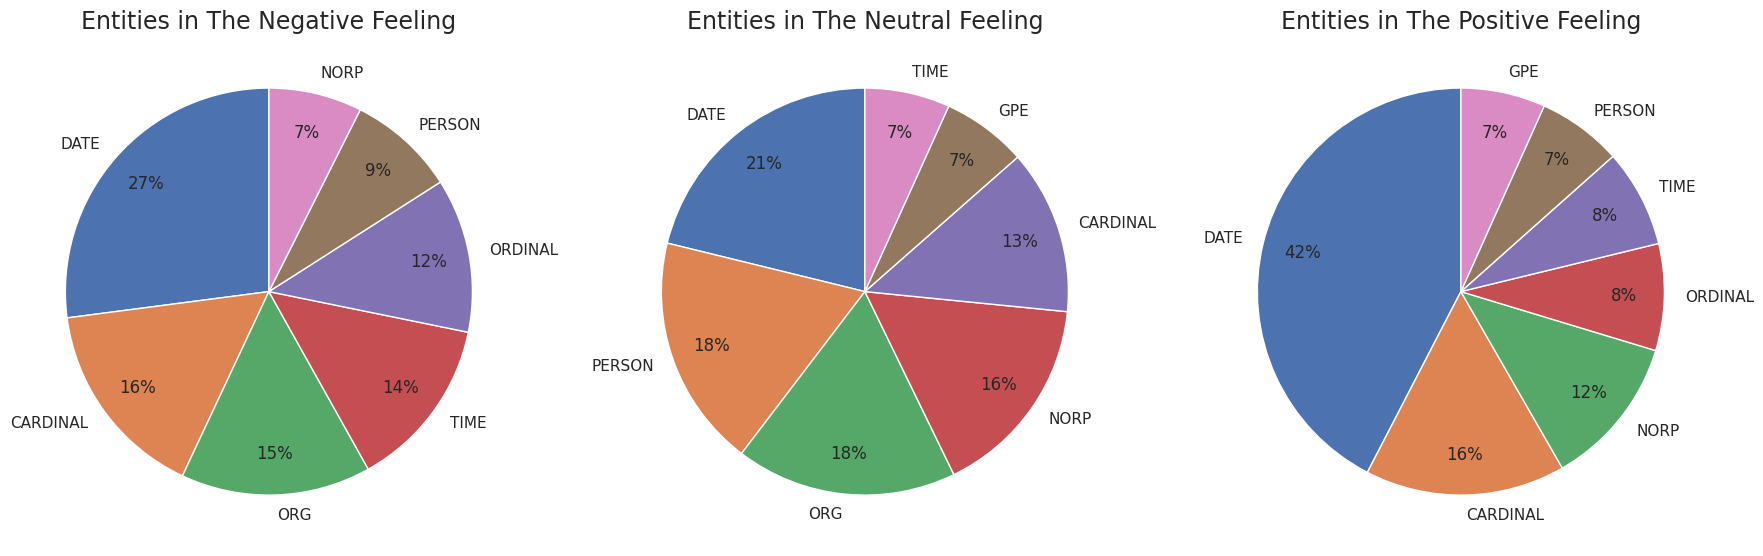

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)

#criamos dataframes com as entidades e as frequências 
positivedfm = pd.DataFrame(list(zip(px,py)), columns = ['Entity','frequency'])
Neutrdfm = pd.DataFrame(list(zip(nx,ny)), columns = ['Entity','frequency'])
Negativedfm = pd.DataFrame(list(zip(Mx,My)), columns = ['Entity','frequency'])


#selecionamos apenas as 8 primieras entidades e plotamos  gráficos com a porcentagem de cada entidade
Negativedfm = Negativedfm[:8]
ax1.pie(Negativedfm['frequency'].values,labels=Negativedfm['Entity'].values,shadow=False, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
ax1.set_title('Entities in The Negative Feeling',fontsize = 17)


#fazemos o semelhante com as  7 primeiras entidades
Neutrdfm = Neutrdfm[:7]
ax2.pie(Neutrdfm['frequency'].values,labels=Neutrdfm['Entity'].values,shadow=False, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
ax2.set_title('Entities in The Neutral Feeling',fontsize = 17)


#o mesmo com as 8 primeiras entidades de classe positiva
positivedfm = positivedfm[:8]
ax3.pie(positivedfm['frequency'].values,labels=positivedfm['Entity'].values,shadow=False, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
ax3.set_title('Entities in The Positive Feeling',fontsize = 17)


fig.set_size_inches(18, 18)
fig.tight_layout()
plt.show()

Nessa pequena parte dos dados encontramos no sentimento negativo mais dados de data, cardinais e de Companies, agencies e institutions, já nos dados da classe neutra a unica diferença da classe negativa é que temos também dados sobre pessoas. Por fim nos dados da classe positiva encontramos mais dados de data, cardinais e de religiões/nacionalidades.


### 6.5 Preparando os dados

Estamos quase saindo da parte de análise exploratória de dados, agora vamos operar em nossos dados apenas através das colunas 'Translated_Review' e 'sentiments'. Retornaremos para nosso conjunto de dados original e vamos alterar os labels de texto para número, como também definir o sentimento de nossos dados em dois tipos, 1 significará sentimento positivo, já 0 definiremos um sentimento negativo. Além disso, faremos com que o sentimento neutro seja do tipo negativo, visto que temos muitos sentimentos positivos.

In [ ]:
#Copiamos os dados para preservação,
DF_ForPrediction = googleplaystore_user_reviews.copy()

#aplicamos as modificações citadas acima,
DF_ForPrediction['sentiments'] = DF_ForPrediction.Sentiment.\
          apply(lambda x : 1 if x == 'Positive' else (0 if (x == 'Negative' or x == 'Neutral') else np.nan)).astype('Int64')

#retiramos as colunas desnecessárias.
DF_ForPrediction.drop(['Sentiment_Polarity','Sentiment_Subjectivity','App'], axis=1,inplace=True)

Após este procedimento retiramos os dados NAN do nosso conjunto de dados.

In [ ]:
DF_ForPrediction.dropna(subset=["sentiments"], how="all", inplace=True)

Não dividimos os labels em positivo, neutro e negativo, pois o código fica demasiado lento já que devemos aplicar diversas técnicas para classificação multi classe, como por exemplo camadas Flatten e BatchNormalization, mas não implementamos a multiclasse. Para vermos se os nossos dados foram preservados utilizamos o método `.value_counts()`.

In [ ]:
DF_ForPrediction['sentiments'].value_counts()

1    23998
0    13434
Name: sentiments, dtype: Int64

In [ ]:
googleplaystore_user_reviews['Sentiment'].value_counts()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

Com esses resultados notamos concordância nos dados, já que somando os labels neutros e negativos ficamos com 13434 labels.

### 6.6 - Dividindo os dados em Treino e Teste

Após removermos nossos rótulos devemos dividi-los em treino e texto, para esta operação pegamos 80% de nossos dados para treino e resto para teste.

In [ ]:
import math 

#80 por cento dos dados serão para treino,
split = math.ceil(len(DF_ForPrediction) * .8)


#convertemos os dados de treino em um numpy array,
train_reviews = DF_ForPrediction['Translated_Review'][:split].to_numpy().astype(str)
train_label = DF_ForPrediction['sentiments'][:split].copy().to_numpy().astype(int)

#fazemos o mesmo para o conjunto de teste com 20% dos dados.
test_reviews = DF_ForPrediction['Translated_Review'][split:].copy().to_numpy().astype(str)
test_label = DF_ForPrediction['sentiments'][split:].copy().to_numpy().astype(int)


Tendo a divisão dos dados em treino e teste vamos neste momento definir alguns parâmetros que serão aplicados em nosso modelo, dessa forma pegamos apenas algumas palavras do vocabulário para treinar nosso modelo (vocab_size = 9352), pois já é suficiente. Além disso assumimos que cada crítica deve ter um comprimento fixo de 180 palavras (max_length = 180), que significa que se um comentário tiver mais do que 180 palavras ele será truncado em 180 palavras, se o comentário tiver menos de 180 palavras ele será preenchido de zeros, visto que vamos tokenizar as palavras (falaremos disso mais tarde). No fim da célula, definimos o tamanho dos vetores de saída de uma camada (Embedding) para cada palavra, para ter 200 dimensões, tal camada será criada posteriormente.


In [ ]:
vocab_size = 9352


max_length = 180 


embedding_dim = 200


Em algumas referências certos autores relatam haver uma regra para definir os valores acima, entretanto como usarei uma busca em grade futuramente testarei diversos valores, com o objetivo de verificar em qual deles o modelo se comporta melhor.

### 6.7 - Limpeza, standardize e tokenizalção com TextVectorization

Chegamos em uma das partes mais interessantes do NLP, que é a tokenização, já fizemos isso anteriormente usando CountVectorizer do sklearn, mas não explicamos com clareza o procedimento. Isso foi feito ,devido ao fato de que gostaríamos de utilizar outro método de processamento que é chamado de camada de pré-processamento of Text Vectorization do keras. Antes disso, vamos criar uma função de pré-processamento para ser usada na TextVectorization, que joga fora tudo que não é caracter e altera o token de UNK para True.

In [ ]:

import string
@tf.keras.utils.register_keras_serializable()
def custom_standardization(initial_string):
    """ Remove everything that is not a character or string in the data """

    no_uppercased = tf.strings.lower(initial_string, encoding='utf-8')

    Aux_data = tf.strings.regex_replace(no_uppercased, rb"<br\s*/?>", b" ")

    change_token = tf.strings.regex_replace(Aux_data, "[UNK]", b"True")

    Clean_data = tf.strings.regex_replace(change_token, b"[^a-zA-Z']", b" ")    
    
    no_punctuations = tf.strings.regex_replace(Clean_data, f"([{string.punctuation}])", r" ")


    return no_punctuations
    

ValueError: ignored

Aqui não retiramos as stop words, pois após executarmos o programa algumas vezes percebemos que tal remoção não agrega relevância significativa no modelo. Por conseguinte definimos a camada de `TextVectorization` tendo o vocabulário de 9352 palavras, truncamento de 180 palavras, um espaço vetorial de incorporação de palavras de 200 dimensões, e a nossa função de pré processamento criada acima. O método TextVectorization codifica as palavras em inteiros, cuja operação tem o significado de buscar palavras no texto e mapeá-las em ids distintos.


In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize = custom_standardization,
    output_mode="int",
    output_sequence_length=max_length,
)


Tendo criado a camada `vectorize_layer` podemos criar o vocabulário aplicando no método `.adapt( )` nos dados de treino.


In [ ]:
vectorize_layer.adapt(train_reviews)

Precisamos também tornar nossos dados para serem tensores, visto que o tensorflow é melhor implementado com  tensores, apesar de aceitar como entrada numpy array. Com esta finalidade, só de alterarmos a dimensão dos dados com `expand_dims()` tornamos o numpy array tensor.


In [ ]:
train_ds = tf.expand_dims(train_reviews,-1)
test_ds = tf.expand_dims(test_reviews,-1)


labelsTrain = tf.expand_dims(train_label,-1)
labelsTest = tf.expand_dims(test_label,-1)

Some models expect a 3D input (nSamples,NTimesteps,NFeatures) and since our `train_ds` and `train_ds` is two-dimensional, let's reshape it.



In [ ]:
train_ds = tf.reshape(train_ds, (train_ds.shape[0],train_ds.shape[1],1))

test_ds = tf.reshape(test_ds, (test_ds.shape[0],test_ds.shape[1],1))

## 7 - Choose and Train The Model

Nesta etapa, analisaremos vários modelos para encontrar o melhor para nosso projeto, mas antes definiremos o método `callbacks.ModelCheckpoint()` que salva o melhor modelo em pontos de verificação ao final de cada época. Aplicaremos também o método `callbacks.EarlyStopping()`, que suspende o treinamento quando não ocorre evolução na validação depois de três épocas (número de vezes em que o algoritmo passará pelos dados de treino). Em ambos os métodos usamos `mode='min'` (já que procuramos o mínimo para perda entre a saída desejada e a saída atual da rede, nos dados de validação) e `monitor='val_loss'`, pois queremos monitorar a perda no conjunto de validação.



In [ ]:
from tensorflow import keras

#Definimos a pasta onde irá residir o modelo,
Model_PATH = os.path.join("Sentimental_Analysis", "Model")
if not os.path.isdir(Model_PATH):
    os.makedirs(Model_PATH)

#usamos o save_best_only=True para salvar o modelo,
save_model_cb = keras.callbacks.ModelCheckpoint("/content/Sentimental_Analysis/Model/best_model.tf", save_best_only=True,mode='min',monitor='val_loss')

#colocamos restore_best_weights=True, para que os pesos do modelo sejam restaurados na época
#com o melhor resultado da medida monitorada
stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=3,
                                                  restore_best_weights=True)


### 7.1 - Baseline Embedding model

#### 7.1.1 - Criando a Rede Neural Embedding

Finalmente chegou a hora de criarmos nossa rede neural, geralmente o primeiro modelo deve ser aquele que será usado para comparar com os outros modelos, para verificar qual deles é o melhor. Dessa forma começarei com um modelo simples, mas adicionarei algumas técnicas que farão o modelo ter um boa avaliação. Redes neurais são baseadas em neurônios biológicos e empregam funções cognitivas, para realizar previsões a partir de dados de entrada, por elas serem fundamentadas em neurônios biológicos que desfrutam de camadas, as redes neurais possuem camadas de entrada, camadas densas e camadas de saída.


Na nossa rede neural usamos `Sequential()` para reunir em um pilha linear as camadas em um arquivo `ctf.keras.Model`, a primeira camada que adicionamos é para garantir que há exatamente uma string de entrada por lote, a próxima é a camada de pré processamento já criada. Seguindo em nossa rede, criamos  uma camada `embedding`  (Transforma inteiros positivos (índices) em vetores densos de tamanho fixo.) tendo como entrada os parâmetros já explicados na seção `6.6`. A próxima camada que adicionamos é a `GlobalAveragePooling1D()`, que no caso 2D geralmente é aplicada em imagens para reduzir a resolução ou a carga computacional, mas no nosso caso podemos usar isto para diminuir o número de parâmetros treináveis. Não utilizei o `Flatten` pois com o Pooling1D obtivemos melhores pontuações.


Por conseguinte, usamos uma técnica de regularização chamada de `Dropout`, que basicamente omite alguns neurônios com taxa de 10% durante o treinamento, mas podem ser ativados em uma etapa posterior. Em seguida usamos camadas densas que vinculam os neurônios de uma camada, com camadas anteriores e aplicamos o inicializador de peso, que estabelece os pesos de uma rede neural para curtos valores aleatórios, além de determinar pontapé inicial para otimizar o modelo de rede neural. Em nosso modelo usamos a `inicialização He` que afere um número arbitrário cuja distribuição de probabilidade é a gaussiana, com desvio padrão  ($√2/n$) , tal que  $n$  é o número de conexões de uma resposta nas camadas e média de 0.0.

Ademais empregamos o que chamamos de função de ativação, que determina a maneira como a soma ponderada da entrada da rede neural é convertida em uma saída de nós em uma camada da rede. A função de ativação que utilizamos é a `PreLU`, que se adapta conforme compreende os parâmetros dos retificadores, e aperfeiçoa a precisão com um custo computacional adicional insignificante. Mas o que é um retificador? Basicamente, uma unidade de ativação linear retificada é uma unidade ou nó, que elabora a função de ativação relatada acima, portanto, as redes retificadas são aquelas que usufruem da função retificadora para as camadas ocultas. Por fim usamos um neurônio de saída e uma função de ativação sigmoid, em que `sigmoid` é  uma função logística cujo resultado pode ser 0 ou 1.


Referências:

https://arxiv.org/abs/1502.01852

https://arxiv.org/abs/1505.00853

https://arxiv.org/abs/1502.01852

http://robotics.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf


In [ ]:
import tensorflow as tf
from tensorflow import keras

modelEmbedding = keras.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
        ),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(rate=0.1),

    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),

    keras.layers.Dense(1, activation="sigmoid")
])


#### 7.1.2 - Compilando e ajustando e avaliando o modelo Embedding

Em modelos de redes neurais devemos compilar o modelo, para inicialmente configurar funções de  perda, otimizadores e quais métricas que serão aplicadas nele. O otimizador que utilizamos é o Adam que é baseado no momento, o momento agrega médias móveis exponencialmente declinantes de gradientes anteriores e prossegue se mobilizando em sua direção. Já o otimizador de Adam  afere as taxas de aprendizado individuais que se adaptam em parâmetros distintos, através de aproximações do primeiro e segundo momentos dos gradientes. Ademais usamos o que chamamos de função de perda, uma função de perda nos retorna valores de erro, ou seja, quanto menor melhor, a função de perda que usaremos é a entropia cruzada binária, que nos informa uma probabilidade de saída entre zero e um, além disso tal função de perda cresce conforme  probabilidade prevista diverge do rótulo presente. Por fim usamos a acurácia como métrica auxiliar.






referencia:

https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/ref=as_li_ss_tl?dchild=1&keywords=deep+learning&qid=1607894380&s=books&sr=1-1&linkCode=sl1&tag=inspiredalgor-20&linkId=8eb6e6e692439ec5bb49cf93ff110f2e&language=en_US

Machine Learning
& Data Science
Blueprints
for Finance


Machine Learning
Theory to Applications

In [ ]:
from tensorflow.keras.optimizers import Adam

def CompileAndFit(Mymodel,Xtrain,Ytrain, Xvalid,Yvalid):

  optimizer = keras.optimizers.Adam(learning_rate=0.003)

  #compilamos o modelo
  Mymodel.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])


  #ajustamos o modelo para 5 épocas, com dados de validação e o checkpoint/early_stopping
  num_epochs = 5
  Mymodel.fit(Xtrain,Ytrain, epochs=num_epochs,validation_data=(Xvalid,Yvalid),callbacks=[save_model_cb,stop_cb])

  return Mymodel

Acima criamos uma função, pois vamos compilar e ajustar o modelo diversas vezes, após tal operação além de chamarmos a função `CompileAndFit()` também contaremos o tempo de compilação dos modelos para comparálos.

In [ ]:
import time 

#timer
inicioOne = time.time()

#primeiro modelo
modelOne = CompileAndFit(modelEmbedding,train_ds, labelsTrain, test_ds,labelsTest)

#end of time count
fimOne = time.time()

Epoch 1/5
936/936 [==============================] - 7s 7ms/step - loss: 0.3982 - accuracy: 0.8105 - val_loss: 0.2759 - val_accuracy: 0.8997
Epoch 2/5
936/936 [==============================] - 8s 8ms/step - loss: 0.1859 - accuracy: 0.9337 - val_loss: 0.2497 - val_accuracy: 0.9053
Epoch 3/5
936/936 [==============================] - 6s 7ms/step - loss: 0.1447 - accuracy: 0.9487 - val_loss: 0.2577 - val_accuracy: 0.9024
Epoch 4/5
936/936 [==============================] - 6s 6ms/step - loss: 0.1201 - accuracy: 0.9572 - val_loss: 0.2887 - val_accuracy: 0.9106
Epoch 5/5
936/936 [==============================] - 6s 6ms/step - loss: 0.0992 - accuracy: 0.9670 - val_loss: 0.3488 - val_accuracy: 0.9061


In [ ]:
from math import fabs

print("Embedding Runtime:",fabs(inicioOne - fimOne), "s")

Embedding Runtime: 33.049760818481445 s


In [ ]:
#evaluation
evaluationEmb = modelOne.evaluate(test_ds,labelsTest)

234/234 [==============================] - 1s 3ms/step - loss: 0.2497 - accuracy: 0.9053


Parece muito bom!

### 7.2 - Model With LSTM

Nesse modelo se empregarmos na camada embedding com o parâmetro `mask_zero=True` podemos melhorar bastante a função de perda, mas o desempenho do modelo fica péssimo se fizermos isso. Digo isso, pois tentei inserir diversos parâmetros na camada lstm como  activation, `recurrent_activation`, `recurrent_dropout`, `use_bias` e `reset_after`, mas mesmo assim o modelo ficou muito lento.

#### 7.2.1 - Criando a rede neural com camada LSTM

After going through the Embedding model we can create another model with small differences, for this purpose we will remove the `GlobalAveragePooling1D` layer and add an LSTM layer with 30 neurons. A Long Short-Term Memory (LSTM) neural network is a recurrent neural network (RNN) architecture that has cells that can understand and identify an important input, contain it in the long-term state, retain it for the desired time, and remove it when desired. Thus, an LSTM unit has an entry gate, an oblivion gate, and an exit gate.


In [ ]:
modelTwo =  keras.Sequential([
            keras.Input(shape=(1,), dtype=tf.string),
            vectorize_layer,
            keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
        ), 

    tf.keras.layers.LSTM(30),                
    tf.keras.layers.Dense(10), 
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#### 7.2.2 - Compilando e avaliando LSTM

Fazemos similar o que feito anteriormente, mas com um modelo diferente.

In [ ]:
import time 

#timer
inicioTwo = time.time()

#segundo modelo
modelTwo = CompileAndFit(modelTwo,train_ds, labelsTrain, test_ds,labelsTest)

#end of time count
fimTwo = time.time()

Epoch 1/5
936/936 [==============================] - 18s 13ms/step - loss: 0.6559 - accuracy: 0.6411 - val_loss: 0.6533 - val_accuracy: 0.6407
Epoch 2/5
936/936 [==============================] - 12s 13ms/step - loss: 0.6534 - accuracy: 0.6412 - val_loss: 0.6532 - val_accuracy: 0.6407
Epoch 3/5
936/936 [==============================] - 12s 13ms/step - loss: 0.6530 - accuracy: 0.6412 - val_loss: 0.6533 - val_accuracy: 0.6407
Epoch 4/5
936/936 [==============================] - 12s 13ms/step - loss: 0.6532 - accuracy: 0.6412 - val_loss: 0.6537 - val_accuracy: 0.6407
Epoch 5/5
936/936 [==============================] - 13s 14ms/step - loss: 0.6530 - accuracy: 0.6412 - val_loss: 0.6532 - val_accuracy: 0.6407


In [ ]:
from math import fabs

print("LSTM Runtime:",fabs(inicioTwo - fimTwo), "s")

LSTM Runtime: 66.99994206428528 s


In [ ]:
#evaluation
evaluationLSTM = modelTwo.evaluate(test_ds,labelsTest)

234/234 [==============================] - 1s 6ms/step - loss: 0.6532 - accuracy: 0.6407


### 7.3 - Model With GRU 

Uma camada Gru (gated recurrent units) é muito semelhante a LSTM, sua principal diferença é que possuem duas portas, uma de atualização e outra de reinicialização, enquanto a unit lstm possui 3 portas. A porta de reinicialização agrupa a entrada vigente com a memória, já a porta de atualização estabelece a memória.



#### 7.3.1 - criando a rede neural GRU

Para criar a rede neural nesse caso fazemos algo muito semelahnte ao feito anteriormente, o diderencial é a camda GRU. Aqui novamente se usassemos `mask_zero=True` teríamos tanto melhor acurácia, quando a função de perda seria melhor, mas o custo computacional é tão grande que não vale a pena.

In [ ]:
modelTree = keras.Sequential([
            keras.Input(shape=(1,), dtype=tf.string),
            vectorize_layer,
            keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
        ), 
    tf.keras.layers.GRU(64),       
    tf.keras.layers.Dense(10), 
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#### 7.3.2 - compilando e avaliando GRU

Compilamos o modelo chamando a dfunção de compilação

In [ ]:
import time 

#timer
inicioTree = time.time()

#terceiro modelo
modelTree = CompileAndFit(modelTree,train_ds, labelsTrain, test_ds,labelsTest)

#end of time count
fimTree = time.time()

Epoch 1/5
936/936 [==============================] - 17s 16ms/step - loss: 0.6556 - accuracy: 0.6400 - val_loss: 0.6543 - val_accuracy: 0.6407
Epoch 2/5
936/936 [==============================] - 13s 14ms/step - loss: 0.6532 - accuracy: 0.6412 - val_loss: 0.6543 - val_accuracy: 0.6407
Epoch 3/5
936/936 [==============================] - 12s 13ms/step - loss: 0.6532 - accuracy: 0.6412 - val_loss: 0.6533 - val_accuracy: 0.6407
Epoch 4/5
936/936 [==============================] - 12s 13ms/step - loss: 0.6529 - accuracy: 0.6412 - val_loss: 0.6533 - val_accuracy: 0.6407
Epoch 5/5
936/936 [==============================] - 12s 13ms/step - loss: 0.6531 - accuracy: 0.6410 - val_loss: 0.6530 - val_accuracy: 0.6407


In [ ]:
from math import fabs

print("GRU Runtime:",fabs(inicioTree - fimTree), "s")

GRU Runtime: 84.49325847625732 s


In [ ]:
#evaluation
evaluationGRU = modelTree.evaluate(test_ds,labelsTest)

234/234 [==============================] - 2s 7ms/step - loss: 0.6530 - accuracy: 0.6407


### 7.4 - Simple RNN Model

Em uma Rede neural recorrente simples,  as informações são processadas da modo similar para cada elemento em uma sequência, de maneira que para haver resultados na saída deve-se realizar cálculos passados. Aqui nós simplesmente adicionamos uma cada RNN simples.





#### 7.4.1 - Criando a rede neural RNN

Aqui construímos uma rede neural muito similar às anteriores, o diferencial é a inserção da camada SimpleRNN.

In [ ]:
import tensorflow as tf

modelFour = keras.Sequential([
            keras.Input(shape=(1,), dtype=tf.string),
            vectorize_layer,
            keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
        ),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(10), 
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#### 7.4.2 - compilando e avaliando a RNN

compilamos o modelo:

In [ ]:
import time 

#timer
inicioFour = time.time()

#terceiro modelo
modelFour = CompileAndFit(modelFour,train_ds, labelsTrain, test_ds,labelsTest)

#end of time count
fimFour = time.time()

Epoch 1/5
936/936 [==============================] - 160s 169ms/step - loss: 0.6557 - accuracy: 0.6391 - val_loss: 0.6533 - val_accuracy: 0.6407
Epoch 2/5
936/936 [==============================] - 158s 168ms/step - loss: 0.6535 - accuracy: 0.6409 - val_loss: 0.6531 - val_accuracy: 0.6407
Epoch 3/5
936/936 [==============================] - 158s 168ms/step - loss: 0.6529 - accuracy: 0.6412 - val_loss: 0.6534 - val_accuracy: 0.6407
Epoch 4/5
936/936 [==============================] - 158s 169ms/step - loss: 0.6530 - accuracy: 0.6412 - val_loss: 0.6536 - val_accuracy: 0.6407
Epoch 5/5
936/936 [==============================] - 158s 169ms/step - loss: 0.6530 - accuracy: 0.6412 - val_loss: 0.6531 - val_accuracy: 0.6407


In [ ]:
from math import fabs

print("RNN Runtime:",fabs(inicioFour - fimFour), "s")

RNN Runtime: 803.2247793674469 s


In [ ]:
#evaluation
evaluationSRNN = modelFour.evaluate(test_ds,labelsTest)

234/234 [==============================] - 4s 17ms/step - loss: 0.6531 - accuracy: 0.6407


### 7.5 - Comparando os modelos

Já sabemos que a primeira rede neural criada é a melhor, mas mesmo assim vamos mostrar os resultados aqui, por isso ilustramos os tempos dos modelos a seguir:

In [ ]:
print("Embedding Runtime:",fabs(inicioOne - fimOne), "s")
print("LSTM Runtime:",fabs(inicioTwo - fimTwo), "s")
print("GRU Runtime:",fabs(inicioTree - fimTree), "s")
print("RNN Runtime:",fabs(inicioFour - fimFour), "s")

Embedding Runtime: 33.049760818481445 s
LSTM Runtime: 66.99994206428528 s
GRU Runtime: 84.49325847625732 s
RNN Runtime: 803.2247793674469 s


e suas respectivas funções de perda:

In [ ]:
print('Embedding: Loss {} , accuracy {}'.format(evaluationEmb[0], evaluationEmb[1]))
print('LSTM: Loss {} , accuracy {} '.format(evaluationLSTM[0], evaluationLSTM[1]))
print('GRU: Loss {} , accuracy {} '.format(evaluationGRU[0], evaluationGRU[1]))
print('SRNN: Loss {} , accuracy {} '.format(evaluationSRNN[0], evaluationSRNN[1]))

Embedding: Loss 0.24972116947174072 , accuracy 0.905289888381958
LSTM: Loss 0.6532366871833801 , accuracy 0.6406625509262085 
GRU: Loss 0.6530477404594421 , accuracy 0.6406625509262085 
SRNN: Loss 0.6530623435974121 , accuracy 0.6406625509262085 


## 8 - Tentando aperfeiçoar o melhor modelo

Agora vamos tentar aprimorar o melhor modelo usando uma biblioteca chamada scikeras:

In [ ]:
!pip install scikeras==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 8.1 - Randomized Search 

Através da biblioteca acima podemos utilizar uma busca em grade, para procurar os melhores hiperparâmetros no nosso modelo. Para usarmos a busca em grade vamos encapsular nosso modelo  em objetos, que tentam reproduzir os classificadores do skid learn. Vamos desenvolver uma função que cria e compila um modelo keras tendo em mente diversos hiperparâmetros. A função a seguir é muito similar ao primeiro modelo que construímos, a grande diferença é que colocamos por default apenas uma camada densa com as regularizações. A pretensão dessa rede neural é classificar o texto de forma binária, e nesse nosso modelo não inserimos a camada `TextVectorization` devido ao fato de resultar em erros já que estamos utilizando um wrapper.





In [ ]:
from numpy.random.mtrand import random_integers
initializer = tf.keras.initializers.HeNormal()

m = tf.keras.metrics.RootMeanSquaredError()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-2,
                vocab_size=vocab_size, 
                embedding_dim=128,
                activation="sigmoid",
                rate=0.1):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dropout(rate=rate))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(rate=rate))
        model.add(keras.layers.PReLU())
    model.add(keras.layers.Dense(1, activation))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model

Além dessa operação devemos alterar a dimensão dos dados com `expand_dims()` e aplicar a camada de pré processamento na mão para evitar erros.


In [ ]:
def to_tensor_vectorize(text):
  result = np.expand_dims(text,-1)
  return vectorize_layer(result)

Antes de utilizar o nosso modelo devemos tornar os tensores para serem numpy array, isso será feito, pois nosso classificador usa algumas funcionalidades do sckid learn, que não tá tão acostumado assim com tensores e dá bastante erro se inserirmos tensores mesmo com o shape bem definido, logo transformarei tensores em numpy arrays.

In [ ]:
#X treino
axuOne = to_tensor_vectorize(train_reviews) #tratamento através da camada TextVectorization
X_train = tf.constant(axuOne) #criamos um tensor constante como esta etapa intermediária
X_train_final = np.array(X_train).astype('int64')#fazemos com que o tensor se torne um numpy array
X_train_final = np.reshape(X_train_final, (X_train_final.shape[0],X_train_final.shape[1],1))# alteramos o shape 


#Treino y
labels = tf.constant(labelsTrain)#criamos um tensor constante como esta etapa intermediária
lb_trainFinal = np.array(labelsTrain).astype('int64')#fazemos com que o tensor se torne um numpy array

#Fazemos o mesmo acima com o x teste e y teste
#teste X
axuOne = to_tensor_vectorize(test_reviews)
X_test = tf.constant(axuOne)
X_test_final = np.array(X_test).astype('int64')
X_test_final = np.reshape(X_test_final, (X_test_final.shape[0],X_test_final.shape[1],1))


#teste y 
labelsT = tf.constant(labelsTest)
lb_testFinal = np.array(labelsTest).astype('int64')

Após todo esse processo criamos um keras classifier através da função `build_model()`, assim o objeto keras criado  pode ser implementado da mesma forma que um classificador do skid learn, ou seja podemos usar o método `fit()`  e `predict()`.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
import numpy
from scikeras.wrappers import KerasClassifier
import random

#Definimos uma lista de neurôneos para a busca,
random.seed(17)
n_neurons = [random.randint(1,300) for i in range(0,6)][3:]


#criamos o objeto KerasClassifier,
model = KerasClassifier(model=build_model,n_hidden=1, n_neurons=30,learning_rate=3e-2,
                vocab_size=vocab_size, 
                embedding_dim=128,
                activation="sigmoid",
                rate=0.1)

#selecionamos todos os parâmetros que queremos comparar.
param_distribs = {
    "n_hidden": [0, 2, 3],
    "embedding_dim": [10, 50, 128],
    "n_neurons": n_neurons,
    "rate": [0.1,0.2,0.3],
    "learning_rate": [3e-1,3e-3,3e-4],
    
     
}


#Usamos a busca randômica pois é mais rápida que a grid search,
grid = RandomizedSearchCV(estimator=model, param_distributions=param_distribs, n_iter=5, cv=5,
                          verbose=2,scoring='accuracy',random_state=42,
                          )


num_epochs = 5

#ajustamos o modelo.
grid_result = grid.fit(X_train_final,lb_trainFinal, epochs=num_epochs,
                       validation_data=(X_test_final,lb_testFinal),
                       callbacks=[save_model_cb, stop_cb])



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Epoch 1/5
749/749 [==============================] - 13s 7ms/step - loss: 28.9899 - accuracy: 0.5712 - val_loss: 0.6502 - val_accuracy: 0.6397
Epoch 2/5
749/749 [==============================] - 4s 5ms/step - loss: 0.7160 - accuracy: 0.6309 - val_loss: 0.6094 - val_accuracy: 0.6600
Epoch 3/5
749/749 [==============================] - 4s 5ms/step - loss: 0.4829 - accuracy: 0.7895 - val_loss: 0.6262 - val_accuracy: 0.7682
Epoch 4/5
749/749 [==============================] - 4s 5ms/step - loss: 1824784.1250 - accuracy: 0.7248 - val_loss: 34183.8281 - val_accuracy: 0.7045
Epoch 5/5
188/188 [==============================] - 0s 2ms/step
[CV] END embedding_dim=10, learning_rate=0.3, n_hidden=3, n_neurons=90, rate=0.1; total time=  30.4s
Epoch 1/5
749/749 [==============================] - 7s 8ms/step - loss: 27.0985 - accuracy: 0.5938 - val_loss: 0.6390 - val_accuracy: 0.6705
Epoch 2/5
749/749 [==============================] - 7s 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.904027 using {'rate': 0.2, 'n_neurons': 149, 'n_hidden': 3, 'learning_rate': 0.0003, 'embedding_dim': 128}


In [ ]:
grid_model = grid_result.best_estimator_.model_
grid_model

In [ ]:
grid_model.evaluate(X_test_final,test_label)

234/234 [==============================] - 1s 3ms/step - loss: 0.2645 - accuracy: 0.9096


[0.26446470618247986, 0.9095644950866699]

### 8.2 - Modelo Final

Agora que temos o melhor modelo, vamos criar a rede neural novamente, pois por algum motivo keras classifier não funciona com uma camada de vetorização de texto.


In [ ]:
end_to_end_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    grid_model,
])

Compilamos  novamente e ajustamos o modelo final.

In [ ]:
end_to_end_model = CompileAndFit(end_to_end_model,train_ds, labelsTrain, test_ds,labelsTest)

Epoch 1/5
936/936 [==============================] - 10s 10ms/step - loss: 0.2422 - accuracy: 0.9022 - val_loss: 0.3639 - val_accuracy: 0.8241
Epoch 2/5
936/936 [==============================] - 8s 9ms/step - loss: 0.1712 - accuracy: 0.9342 - val_loss: 0.2580 - val_accuracy: 0.8983
Epoch 3/5
936/936 [==============================] - 6s 7ms/step - loss: 0.1376 - accuracy: 0.9486 - val_loss: 0.3186 - val_accuracy: 0.9036
Epoch 4/5
936/936 [==============================] - 6s 7ms/step - loss: 0.1266 - accuracy: 0.9530 - val_loss: 0.3081 - val_accuracy: 0.8973
Epoch 5/5
936/936 [==============================] - 6s 6ms/step - loss: 0.1009 - accuracy: 0.9621 - val_loss: 0.4092 - val_accuracy: 0.8967


salvamos o modelo por prevenção:

In [ ]:
end_to_end_model.save("/content/Sentimental_Analysis/Model/final_model.tf")
#end_to_end_model.save("/content/drive/MyDrive/Colab Notebooks/Projetos/Machine Learning/linguagem natural/final_model.tf")

Vamos testar o modelo salvo para deploy:

In [ ]:
#lemos o modelo
#FinalModel = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Projetos/Machine Learning/linguagem natural/final_model.tf")
FinalModel = keras.models.load_model("/content/Sentimental_Analysis/Model/final_model.tf")

#pegamos um exemplo de crítica
sample_text = tf.expand_dims(['This app is kinda bad'],-1)

#realizamos a previsão
predictions = FinalModel.predict(sample_text)
	
#mostramos o resultado
print(*predictions[0],sep = ' ')

0.0010380447


Notamos que o resultado é correto, pois realizamos uma crítica negativa e o modelo previu corretamente que a crítica é negativa com o rótulo 0, se fosse próximo de 1 seria positiva.